<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_NLP_Optimize_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2023-07-07 17:57:16--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.143.101, 74.125.143.139, 74.125.143.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.143.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uiku6dp3h22ifbm59inghf9nrtsct98p/1688752575000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=900b2928-c228-4e50-b224-481d04581d81 [following]
--2023-07-07 17:57:19--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uiku6dp3h22ifbm59inghf9nrtsct98p/1688752575000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=900b2928-c228-4e50-b224-481d04581d81
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.128.132, 2a00:1450:4013:c02::84
Connecting to doc-04

In [3]:
# preprocessing

def tokenize_corpus(corpus, num_words=-1):
  # fit the tokenizer to the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # remove punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # convert to lowercase
  dataset[field] = dataset[field].str.lower()
  # make one long string split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # remove trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  #remove empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
# read 250 songs from the dataset
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# create the corpus using the text column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

print(total_words)

2000


<ipython-input-3-408cdce278c6>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')


In [5]:
# create sequences and labels
sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    sequences.append(n_gram_sequence)

# pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# split sequences between the input and output predictions
input_sequences, labels = sequences[:,:-1], sequences[:,-1]

# one hot encoding
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
# train a better text generation model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 32s 15ms/step - loss: 5.9810 - accuracy: 0.0471
Epoch 2/100
1480/1480 [==============================] - 15s 10ms/step - loss: 5.6826 - accuracy: 0.0518
Epoch 3/100
1480/1480 [==============================] - 17s 11ms/step - loss: 5.4297 - accuracy: 0.0807
Epoch 4/100
1480/1480 [==============================] - 15s 10ms/step - loss: 5.2364 - accuracy: 0.1059
Epoch 5/100
1480/1480 [==============================] - 17s 12ms/step - loss: 5.1009 - accuracy: 0.1218
Epoch 6/100
1480/1480 [==============================] - 21s 14ms/step - loss: 4.9743 - accuracy: 0.1323
Epoch 7/100
1480/1480 [==============================] - 20s 13ms/step - loss: 4.8623 - accuracy: 0.1422
Epoch 8/100
1480/1480 [==============================] - 17s 12ms/step - loss: 4.7581 - accuracy: 0.1536
Epoch 9/100
1480/1480 [==============================] - 14s 10ms/step - loss: 4.6634 - accuracy: 0.1635
Epoch 10/100
1480/1480 [==============================]

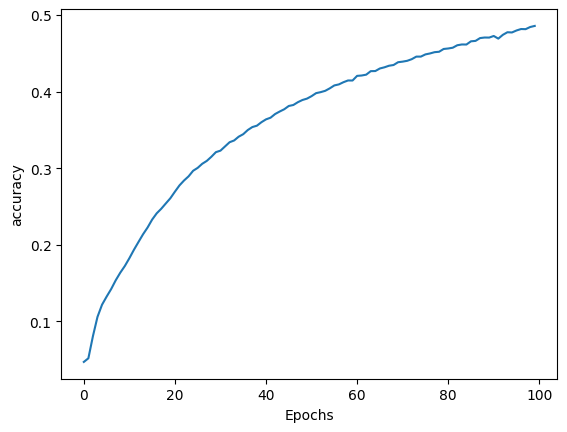

In [7]:
# visualize the data
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [11]:
# generate lyrics with less repitition
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted = np.argmax(model.predict(token_list), axis=-1)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 22ms/step
im feeling chills the sun yeah in my life is a road runner wedding over i dont know what you to cutie to cutie hearted fantasy i walks mans christmas coming through my fingers all the only way i am i missed boys that you honey love is more i love it had it had it shine shine on it shine that goes for the intention that he vegas high temperature he instead instead instead cest didnt wants what it as monkey so far away from the other side of the night yeah we met love band cover and drawn my friend backstage


In [30]:
# switch model.predict_classes to model.predict_proba
# use np.random.choice to make the output more random
seed_text ="I'm feeling chills"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
# run this cell multiple times to see the variance
print(predicted)

1/1 [==============================] - 0s 22ms/step
1


In [33]:
# use this process for the full output generation
seed_text = "I'm feeling chills"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 23ms/step
I'm feeling chills the beat of the world found late who for we dont dont know you great to fancy door up yonder cause you leave it aint hard on a fellow man shining that well same he do her loved the music hard you music still free away chuck away chuck away renee brighter heels for sailing promises you want it ever hope love i love it shine let me go cant fancy me i cant refuse it until the sword of a helping hand in love a midnight way it last show that our love of own treat that well that
